### IGNORING WARNINGS 

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

### IMPORTING AND CHECKING DATASET

In [3]:
import pandas as pd
df = pd.read_csv('train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [5]:
mv=df.isna().sum()
mv[mv>0]

Series([], dtype: int64)

### SEPERATING X AND Y

In [6]:
x = df.drop(columns=['Product ID', 'id', 'Machine failure'])
y = df[['Machine failure']]

In [7]:
x.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0


In [8]:
y.head()

,Machine failure
0,0
1,0
2,0
3,0
4,0


### SEPERATING CAT AND CON FEATURE

In [9]:
cat = list(x.columns[x.dtypes=='object'])
con = list(x.columns[x.dtypes!='object'])

In [10]:
cat

['Type']

In [11]:
con

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

### CREATING PREPROCESSING PIPELINE

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [13]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [14]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ordinal', OrdinalEncoder())])

In [15]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                          ('cat', cat_pipe1, cat)]).set_output(transform='pandas')

In [16]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF',
                                  'RNF']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Type'])])

In [17]:
x_pre = pre1.fit_transform(x)
x_pre.head()

,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,1.0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,2.0
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,1.0
3,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,1.0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,2.0


### PERFORMING MUTUAL INFO SCORES

In [18]:
from sklearn.feature_selection import mutual_info_classif
mis = mutual_info_classif(x_pre, y)
mis

array([0.00572197, 0.00202775, 0.01892488, 0.01947268, 0.00708188,
       0.00739416, 0.02436358, 0.01128685, 0.01918784, 0.00089583,
       0.01077511])

In [19]:
mis = pd.Series(mis)
mis.index = x_pre.columns
mis = mis.sort_values(ascending=False)
mis

num__HDF                        0.024364
num__Torque [Nm]                0.019473
num__OSF                        0.019188
num__Rotational speed [rpm]     0.018925
num__PWF                        0.011287
cat__Type                       0.010775
num__TWF                        0.007394
num__Tool wear [min]            0.007082
num__Air temperature [K]        0.005722
num__Process temperature [K]    0.002028
num__RNF                        0.000896
dtype: float64

<Axes: title={'center': 'MUTUAL INFO SCORES'}>

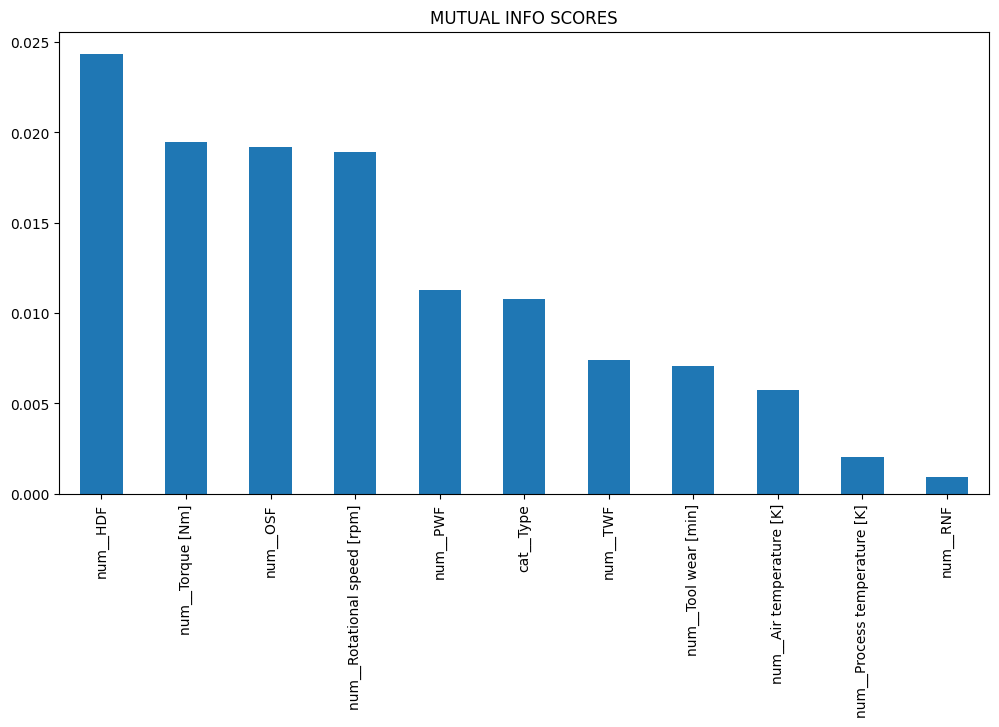

In [20]:
mis.plot(kind='bar', title='MUTUAL INFO SCORES', figsize=(12,6))

### SELECTING 11 FEATURE

In [21]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=11)
sel.fit(x_pre, y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Air temperature [K]', 'num__Process temperature [K]',
       'num__Rotational speed [rpm]', 'num__Torque [Nm]',
       'num__Tool wear [min]', 'num__TWF', 'num__HDF', 'num__PWF',
       'num__OSF', 'num__RNF', 'cat__Type'], dtype=object)

In [22]:
imp_cols = []
for i in sel_cols:
    sc = i.split('__')[1]
    imp_cols.append(sc)

In [23]:
imp_cols

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF',
 'Type']

In [24]:
x_imp = x[imp_cols]
x_imp

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,L
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,M
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,L
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,L
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,M
...,...,...,...,...,...,...,...,...,...,...,...
136424,300.1,311.4,1530,37.5,210,0,0,0,0,0,M
136425,297.5,308.5,1447,49.1,2,0,0,0,0,0,H
136426,300.5,311.8,1524,38.5,214,0,0,0,0,0,L
136427,301.7,310.9,1447,46.3,42,0,0,0,0,0,L


### SEPERATING CAT AND CON FOR SELECTED COLUMNS

In [25]:
cat_sel = list(x_imp.columns[x_imp.dtypes=='object'])
con_sel = list(x_imp.columns[x_imp.dtypes!='object'])

In [26]:
cat_sel

['Type']

In [27]:
con_sel

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

### CREATING A FINAL PREPROCESSING PIPELINE

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [30]:
cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [31]:
pre2 = ColumnTransformer([('num', num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [32]:
x_sel_pre = pre2.fit_transform(x_imp)
x_sel_pre.head()

,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
3,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0


### APPLYING TRAIN TEST SPLIT

In [33]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_sel_pre, y, test_size=0.2, random_state=21)

In [34]:
xtrain.shape

(109143, 13)

In [35]:
xtest.shape

(27286, 13)

### ALGO EVALUATION 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [37]:
dct = {'LOGISTIC' : LogisticRegression(),
       'DECISION TREE' : DecisionTreeClassifier(),
       'RANDOM FOREST' : RandomForestClassifier(),
       'GRADIENT BOOST' : GradientBoostingClassifier()}

In [38]:
dct.items()

dict_items([('LOGISTIC', LogisticRegression()), ('DECISION TREE', DecisionTreeClassifier()), ('RANDOM FOREST', RandomForestClassifier()), ('GRADIENT BOOST', GradientBoostingClassifier())])

### FITTING THE MODEL AND EVALUATING THE RESULTS

In [39]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [40]:
tr = []
tr_cv = []
ts = []
for name, model in dct.items():
    model.fit(xtrain, ytrain)
    ypred_tr = model.predict(xtrain)
    ypred_ts = model.predict(xtest)
    f1_tr = f1_score(ytrain, ypred_tr)
    f1_ts = f1_score(ytest, ypred_ts)
    scores = cross_val_score(model, xtrain, ytrain, cv = 5, scoring='f1_macro')
    f1_cv = scores.mean()
    tr.append(f1_tr)
    ts.append(f1_ts)
    tr_cv.append(f1_cv)



    print(f'MODEL NAME : {name}\n')
    print(f'TRAIN F1 : {f1_tr:.4f}')
    print(f'TRAIN F1 CROSS VALIDDATED : {f1_cv:.4f}')
    print(f'TEST F1 : {f1_ts:.4f}')
    print('\n===========================================================\n')
    

MODEL NAME : LOGISTIC

TRAIN F1 : 0.8651
TRAIN F1 CROSS VALIDDATED : 0.9310
TEST F1 : 0.8530


MODEL NAME : DECISION TREE

TRAIN F1 : 0.9956
TRAIN F1 CROSS VALIDDATED : 0.8709
TEST F1 : 0.7583


MODEL NAME : RANDOM FOREST

TRAIN F1 : 0.9950
TRAIN F1 CROSS VALIDDATED : 0.9290
TEST F1 : 0.8556


MODEL NAME : GRADIENT BOOST

TRAIN F1 : 0.8733
TRAIN F1 CROSS VALIDDATED : 0.9287
TEST F1 : 0.8530




### SEEING ABOVE RESULTS IN DATAFRAME

In [41]:
list(dct.keys())

['LOGISTIC', 'DECISION TREE', 'RANDOM FOREST', 'GRADIENT BOOST']

In [42]:
results_dct = {'MODEL_NAME' : list(dct.keys()),
               'TRAIN F1' : tr,
               'TEST F1' : ts,
               'TRAIN F1 CV' : tr_cv}

In [43]:
results_df = pd.DataFrame(results_dct)
results_df

,MODEL_NAME,TRAIN F1,TEST F1,TRAIN F1 CV
0,LOGISTIC,0.865113,0.852980,0.931022
1,DECISION TREE,0.995620,0.758305,0.870901
2,RANDOM FOREST,0.995039,0.855643,0.928975
3,GRADIENT BOOST,0.873331,0.852980,0.928675


In [44]:
results_df = results_df.sort_values(by='TEST F1', ascending=False)
results_df

,MODEL_NAME,TRAIN F1,TEST F1,TRAIN F1 CV
2,RANDOM FOREST,0.995039,0.855643,0.928975
0,LOGISTIC,0.865113,0.852980,0.931022
3,GRADIENT BOOST,0.873331,0.852980,0.928675
1,DECISION TREE,0.995620,0.758305,0.870901


### RANDOM FOREST MODEL

In [45]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1, max_depth=1, min_samples_split=5, min_samples_leaf=3, criterion='gini')
model.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=1, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=1)

In [46]:
model.score(xtrain, ytrain)

0.9865772426999441

In [47]:
model.score(xtest, ytest)

0.9867331232133695

### HYPERPARAMETER TUNING

In [48]:
params = {'n_estimators':[10,50,100],
          'max_depth' : [2,3,4,5,6,7],
          'min_samples_split' : [5,6,7,8,9],
          'criterion' : ['gini', 'entropy']}

In [49]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
rscv = RandomizedSearchCV(rfc, param_distributions=params, cv=5, scoring='f1_macro')
rscv.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_split': [5, 6, 7, 8, 9],
                                        'n_estimators': [10, 50, 100]},
                   scoring='f1_macro')

In [50]:
rscv.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'max_depth': 7,
 'criterion': 'gini'}

In [51]:
rscv.best_score_

0.9310265322575727

In [53]:
best_rfc = rscv.best_estimator_
best_rfc

RandomForestClassifier(max_depth=7, min_samples_split=5)

### EVALUATING MODEL IN TRAIN AND TEST

In [54]:
best_rfc.score(xtrain, ytrain)

0.996270947289336

In [55]:
best_rfc.score(xtest, ytest)

0.9959686286007476

### SHOWING ROC AUC CURVE

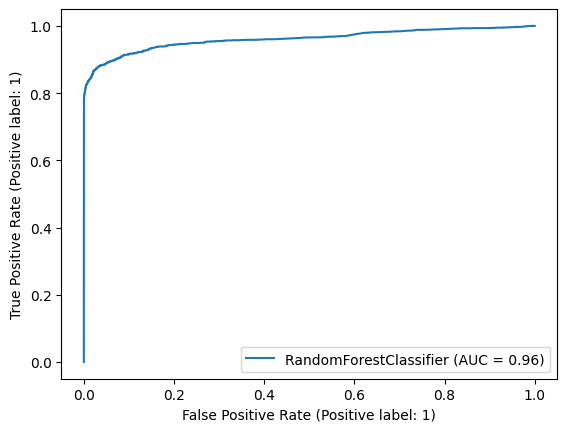

In [56]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_rfc, xtrain, ytrain)

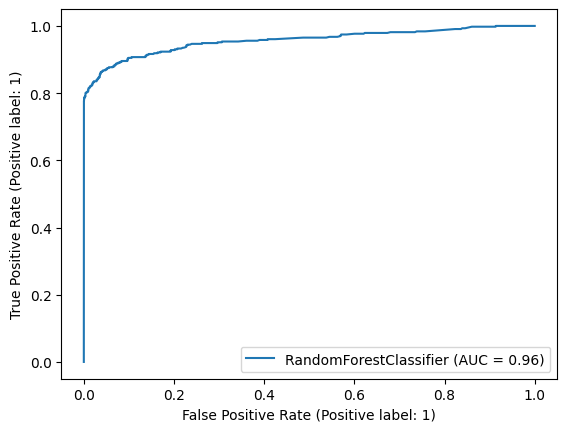

In [57]:
RocCurveDisplay.from_estimator(best_rfc, xtest, ytest)

### PREDICTING OUT OF SAMPLE DATA

In [58]:
xnew = pd.read_csv('test.csv')
xnew.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [59]:
xnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90954 entries, 0 to 90953
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       90954 non-null  int64  
 1   Product ID               90954 non-null  object 
 2   Type                     90954 non-null  object 
 3   Air temperature [K]      90954 non-null  float64
 4   Process temperature [K]  90954 non-null  float64
 5   Rotational speed [rpm]   90954 non-null  int64  
 6   Torque [Nm]              90954 non-null  float64
 7   Tool wear [min]          90954 non-null  int64  
 8   TWF                      90954 non-null  int64  
 9   HDF                      90954 non-null  int64  
 10  PWF                      90954 non-null  int64  
 11  OSF                      90954 non-null  int64  
 12  RNF                      90954 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 9.0+ MB


### APPLYING PRE.TRANSFORM

In [60]:
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
0,1.308759,1.125444,-0.153753,-0.276240,-0.694271,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
1,0.986567,0.764477,1.388744,-1.358313,-1.366516,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
2,0.771772,0.331317,0.033653,-0.311525,-0.131461,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
3,0.127386,-0.246230,-0.297912,0.852880,-1.554119,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
4,1.899446,1.702992,-0.038426,0.111895,0.149943,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0


### PREDICTING THE FILE

In [61]:
preds = best_rfc.predict(xnew_pre)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [62]:
best_rfc.classes_

array([0, 1], dtype=int64)

In [63]:
probs = best_rfc.predict_proba(xnew_pre)[:, 1]
probs[0:5]

array([0.00502993, 0.00410938, 0.00325172, 0.00272515, 0.00461198])

### SAVING ABOVE RESULTS IN DATAFRAME

In [64]:
df_final = xnew[['Product ID']]
df_final

,Product ID
0,L50896
1,L53866
2,L50498
3,M21232
4,M19751
...,...
90949,L51130
90950,L47783
90951,L48097
90952,L48969


In [65]:
df_final['mfailure_pred']=preds
df_final['mfailure_prob']=probs

In [66]:
df_final

,Product ID,mfailure_pred,mfailure_prob
0,L50896,0,0.005030
1,L53866,0,0.004109
2,L50498,0,0.003252
3,M21232,0,0.002725
4,M19751,0,0.004612
...,...,...,...
90949,L51130,0,0.005053
90950,L47783,0,0.003039
90951,L48097,0,0.003726
90952,L48969,0,0.002883


### SAVING ABOVE RESULTS TO RESULTS.CSV

In [69]:
df_final.to_csv('results.csv', index=False)

In [70]:
df_final['mfailure_pred'].value_counts()

mfailure_pred
0    89854
1     1100
Name: count, dtype: int64

### PLOTTING COUNTPLOT FOR ABOVE RESULTS

<Axes: title={'center': 'COUNTPLOT FOR MACHINE FAILURE'}, xlabel='mfailure_pred'>

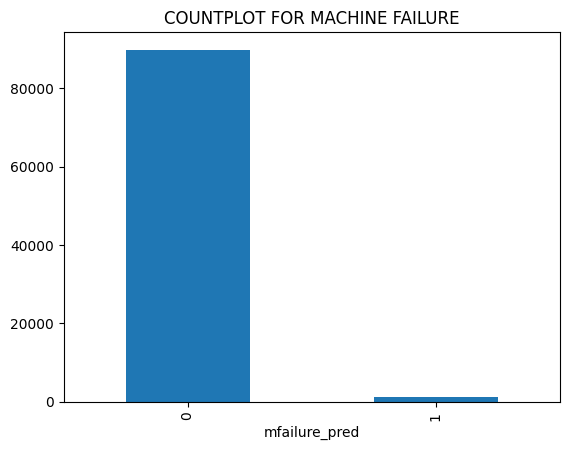

In [71]:
df_final['mfailure_pred'].value_counts().plot(kind='bar', title='COUNTPLOT FOR MACHINE FAILURE')